In [353]:
# imports
import meshplot as mp
import matplotlib.pyplot as plt
import nibabel as nb
import numpy as np
import igl_testing
from ipywidgets import interactive, fixed, FloatSlider
import ipywidgets as widgets

In [254]:
# define metrics for comparing operators
def squared_difference(x, y):
    return np.square(x - y)

def percentage_difference(x, y):
    return (y-x / y) * 100

def abs_percentage_difference(x, y):
    return np.abs((x-y / y) * 100)

In [256]:
# load surface
surface_name = '/home/ibmeuser/Documents/Data/hcp-asl/HCP_asl_min_req_mean_16_onsurface/HCA6002236/T1w/fsaverage_LR32k/HCA6002236_V1_MR.L.inflated.32k_fs_LR.surf.gii'
surface = nb.load(surface_name)
v, f = surface.agg_data()

In [459]:
def func_and_curv(surface_name, func, s):
    surface = nb.load(surface_name)
    v, f = surface.agg_data()
    # evaluate function and curvature
    u = igl_testing.functions.FUNCS[func](v, s)
    an_curv = igl_testing.curvatures.CURVS[func](v, s)
    curv_min, curv_max = [an_curv.min(), an_curv.max()]
    print(f"Min curvature = {curv_min:0.2f}. Max curvature = {curv_max:0.2f}")
    # plot
    data = mp.subplot(v, f, c=u, s=[1, 2, 0])
    mp.subplot(v, f, c=an_curv, s=[1, 2, 1], data=data)
    return u, an_curv, curv_min, curv_max

In [457]:
# evaluate function at each vertex
functions = [*igl_testing.functions.FUNCS.keys()]
function_plot = interactive(
    func_and_curv,
    surface_name=fixed(surface_name),
    func=widgets.Dropdown(options=functions, description='Function'),
    s=FloatSlider(min=0.1, max=1.5, step=0.1, value=0.75, continuous_update=False, description='Speed')
)
output = function_plot.children[-1]
output.layout.height='450px'
display(function_plot)

interactive(children=(Dropdown(description='Function', options=('sumsincosxy', 'sumsincosxz', 'sumsincosyz'), …

In [258]:
# get LBO of surface and apply to function
lbo = igl_testing.testing_igl.get_lbo(v, f, area_type='voronoi')
lbo_u = lbo.dot(u)
clipped_lbo_u = np.clip(lbo_u, curv_min, curv_max)

In [259]:
# get curvature via the graph laplacian
gl = igl_testing.testing_igl.get_graph_laplacian(f)
gl_u = gl.dot(u)
clipped_gl_u = np.clip(gl_u, curv_min, curv_max)

/home/ibmeuser/anaconda3/envs/igl/lib/python3.8/site-packages/scipy/sparse/_index.py:124: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [260]:
# plot the 3 curvatures for comparison
curv_plots = mp.subplot(v, f, c=an_curv, s=[1, 3, 0])
# show clipped curvatures so that we can compare between plots
mp.subplot(v, f, c=clipped_lbo_u, s=[1, 3, 1], data=curv_plots)
mp.subplot(v, f, c=clipped_gl_u, s=[1, 3, 2], data=curv_plots)

In [261]:
# plot the difference between analytic and estimated curvature
sq_diff_lbo = squared_difference(lbo_u, an_curv)
mean_sq_diff = sq_diff_lbo.mean()
std_sq_diff = sq_diff_lbo.std()
print(f"Mean squared difference = {mean_sq_diff}")
print(f"S.D. of squared difference = {std_sq_diff}")
clipped_sq_diff_lbo = np.clip(sq_diff_lbo, 0, mean_sq_diff + 2*std_sq_diff)
perc_diff_lbo = percentage_difference(lbo_u, an_curv)
perc_max = 200
clipped_perc_diff_lbo = np.clip(perc_diff_lbo, -perc_max, perc_max)

Mean squared difference = 0.024140316992998123
S.D. of squared difference = 0.0246276818215847


In [262]:
# get difference between analytic and gl-estimated curvature
sq_diff_gl = squared_difference(an_curv, gl_u)
clipped_sq_diff_gl = np.clip(sq_diff_gl, 0, mean_sq_diff + 2*std_sq_diff)
perc_diff_gl = percentage_difference(gl_u, an_curv)
clipped_perc_diff_gl = np.clip(perc_diff_gl, -perc_max, perc_max)

In [263]:
# plot squared differences
sq_diff_plots = mp.subplot(v, f, c=clipped_sq_diff_lbo, s=[1, 2, 0])
mp.subplot(v, f, c=clipped_sq_diff_gl, s=[1, 3, 1], data=sq_diff_plots)

In [264]:
# plot percentage differences
perc_diff_plots = mp.subplot(v, f, c=clipped_perc_diff_lbo, s=[1, 2, 0])
mp.subplot(v, f, c=clipped_perc_diff_gl, s=[1, 3, 1], data=perc_diff_plots)

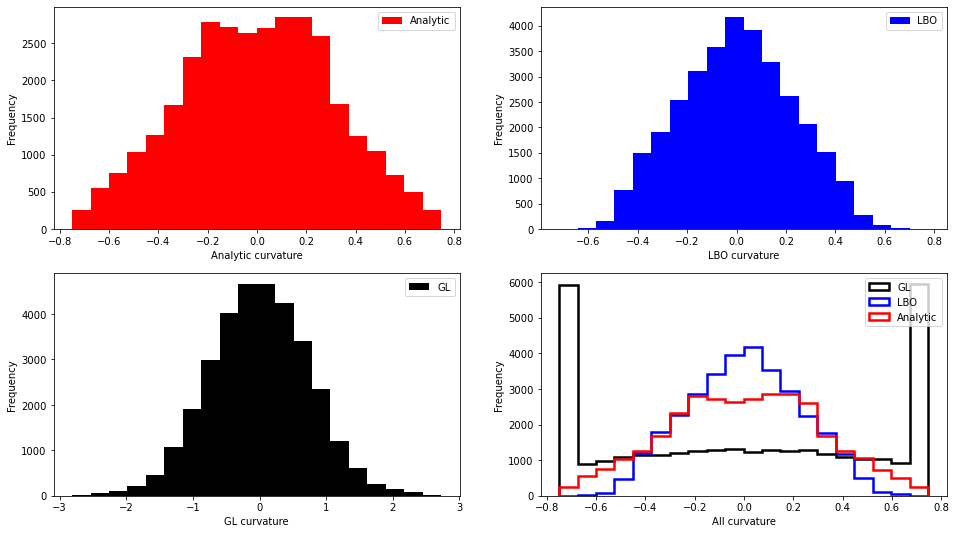

In [265]:
# show histograms of raw values
nbins = 20
colours = ('r', 'b', 'k')
labels = ('Analytic', 'LBO', 'GL', 'All')
fig, axs = plt.subplots(2, 2, figsize=(16, 9))
for ax, label, curv, colour in zip(axs.reshape(-1,), 
                                   labels, 
                                   (an_curv, lbo_u, gl_u, (an_curv, clipped_lbo_u, clipped_gl_u)), 
                                   (*colours, colours)):
    if label == 'All':
        ax.hist(curv, nbins, color=colour, label=labels, histtype='step', stacked=False, fill=False, linewidth=2.5)
    else:
        ax.hist(curv, nbins, color=colour, label=label)
    ax.set_xlabel(f"{label} curvature")
    ax.set_ylabel("Frequency")
    ax.legend()

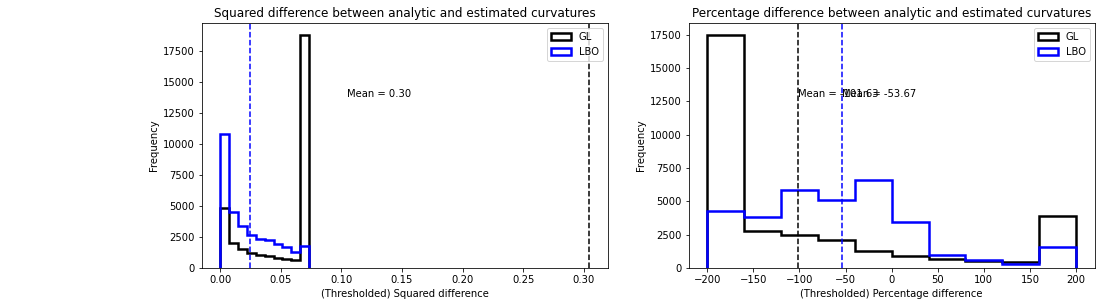

In [266]:
# summary statistics
mean_sq_err_lbo = sq_diff_lbo.mean()
mean_sq_err_gl = sq_diff_gl.mean()
mean_perc_diff_lbo = perc_diff_lbo.mean()
mean_perc_diff_gl = perc_diff_gl.mean()

# show histograms of metrics
nbins = 10
colours = ('b', 'k')
labels = ('LBO', 'GL')
metrics = ('Squared difference', 'Percentage difference')
metric_diffs = (
    (clipped_sq_diff_lbo, clipped_sq_diff_gl),
    (clipped_perc_diff_lbo, clipped_perc_diff_gl)
)
summary_stats = (
    (mean_sq_err_lbo, mean_sq_err_gl),
    (mean_perc_diff_lbo, mean_perc_diff_gl)
)
fig, axs = plt.subplots(1, 2, figsize=(16, 4.5))
for ax, metric, diffs, summary in zip(axs, metrics, metric_diffs, summary_stats):
    # unpacking
    diff_lbo, diff_gl = diffs
    texts = [f"Mean = {sum_stat:.2f}" for sum_stat in summary]
    # plot
    ax.hist((diff_lbo, diff_gl), nbins, color=colours, label=labels, histtype='step', stacked=False, fill=False, linewidth=2.5)
    for sum_stat, colour, text in zip(summary, colours, texts):
        ax.axvline(sum_stat, color=colour, linestyle="--")
        ax.annotate(text, xy=(sum_stat-0.2, 0.7*ax.get_ylim()[1]), xycoords='data')
    ax.set_xlabel(f"(Thresholded) {metric}")
    ax.set_ylabel("Frequency")
    ax.set_title(f"{metric} between analytic and estimated curvatures")
    ax.legend(loc=1)